## kMeans Clustering

In this lesson we consider another example of unsupervised learning, kMeans clustering, which is particularly useful for classification problems. We will cover a basic description of how this algorithm works, how the optimal number of clusters can be chosen and consider applications to classifying digits and image processing.

kMeans clustering works by investigating the features of instances and assuming that samples that lie close to each other in feature space will have the same labels. For example, if we are trying to classify adult animals and we have the features diet, weight, height, length and colour, we would expect that the animals that lie in clusters in feature space are the same species. Then if we know the species of one animal in each cluster, we can label that cluster as a known species. As we increase the number of independent features we would expect the clusters to become more distinct in feature space.


First we import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from sklearn.metrics import confusion_matrix
from logitplots import plt_confusion_matrix, plt_decision_boundaries

## Contents

* Classifying Blobs
* Classifying Digits
* Image Compression and Segmentation

### Classifying Blobs

We first consider a simple example using the `sklearn` function `make_blobs`. This creates a set of random clusters, which for the given parameters, we can see are relatively distinct.

Matplotlib is building the font cache; this may take a moment.


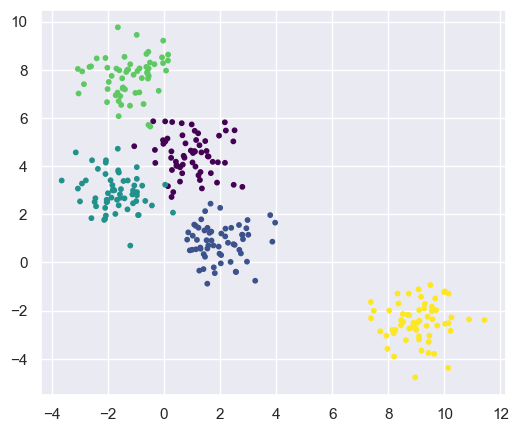

In [2]:
from sklearn.datasets import make_blobs
# create 5 blobs of points with coordinates X and labels y_true
# cluster_std controls the size of the blobs
X, y_true = make_blobs(n_samples=300, centers=5, cluster_std=.8, random_state=0)
fig = plt.figure(figsize=(6, 5)) # set up a figure of size 6 x 5
# scatter plots of the blobs coloured by their labels
plt.scatter(X[:,0], X[:,1], c=y_true, s=10, cmap='viridis');

To use KMeans clustering we need to specify the number of clusters. In this case, it is obvious that we should choose `n_clusters=5`. Later we will show how to choose the correct number of clusters by using scores that are output by `KMeans`. The use of `KMeans` is the same as for other `sklearn` functions: we instantatiate the model with the chosen parameters, we fit the data to the model, and then we can use the model to predict values. In this case, this is simply the index for the cluster. However, if we know target properties for some of the members of the cluster, we can associate these predictions with all members of the cluster. Again, as this is unsupervised learning, we do not need to split the data into testing and training sets, and we only need to fit the data features to the model.

Fit the data for `KMeans` is very simple. The data is assigned to the cluster within the nearest centre.

The plot below shows the boundaries for each cluster, which will be line segments or hyperplanes in higher dimensions, and the centre for each cluster shown as a cross. In this case, `Kmeans` is fairly successful in predicting the clusters. There are some misclassifications where there is crossover between the clusters, but generally it predicts the true values. 

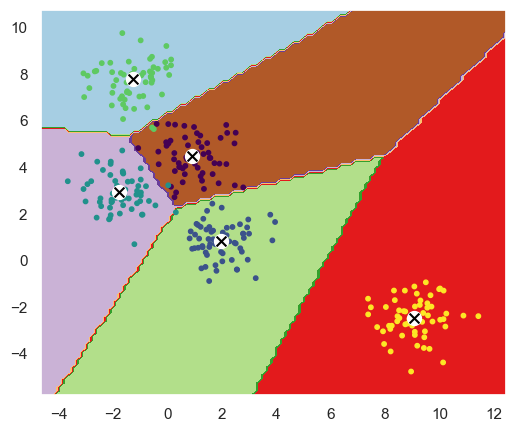

In [3]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5) # instantatiate the model with default values and 5 clusters
kmeans.fit(X) # fit the data to the model
y_kmeans = kmeans.predict(X) # use the model to predict labels for each cluster

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # find the minimum and maximum of the first feature
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # find the minimum and maximum of the second feature
# create a rectangular grid which goes from the minimum to maximum values in step-size of h
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),np.linspace(y_min, y_max, 100)) 

fig = plt.figure(figsize=(6, 5)) # set up a figure of size 10 x 5
plt_decision_boundaries(kmeans,xx,yy) # plot the decision boundaries
# scatter plot of the data points coloured by their true values
plt.scatter(X[:,0], X[:,1], s=10, c=y_true, cmap='viridis') 
# get the values of the centers from the model
centers = kmeans.cluster_centers_
# plot the centre posititions with a black cross on a white circle
plt.scatter(centers[:,0], centers[:,1], c='white', s=100, alpha=1.)
plt.scatter(centers[:,0], centers[:,1], c ='black', marker='x', s=50);

To understand how `KMeans` calculates the clusters, we can view the evolution of the centers and cluster boundaries. If we specify `init='random'` and `n_init=1`, then the model is fit to the data using random initial conditions and one run for each initial condition. We will explain later how these differ from the default values. The first step is that 5 points in the data set are chosen at random as the initial cluster centres. Then each point is assigned to the closest cluster centre. For each cluster the centre is recalculated as the average position of the members of the cluster. The process is then repeated until the centres converge (stop moving) or the maximumum number of iterations (specified by `max_iter`) is reached. The algorithm is assured to converge, although the number of iterations for this to occur will depend on the data set, and the parameters of the algorithm. Also, the final classification will be dependent on the choice of initial condition.

In the sequence below it is apparent that the centre in the blue region converges rapidly. After two iterations it does not move significantly. However, for the other regions, which are much closer together, the convergence is slower. Initially the cluster in the top left-hand corner is split into two, but gradually one of the cluster centres moves toward the cluster in the middle of the figure. At the same rate, the cluster in the brown region is slowly pushed downwards to the correct position.

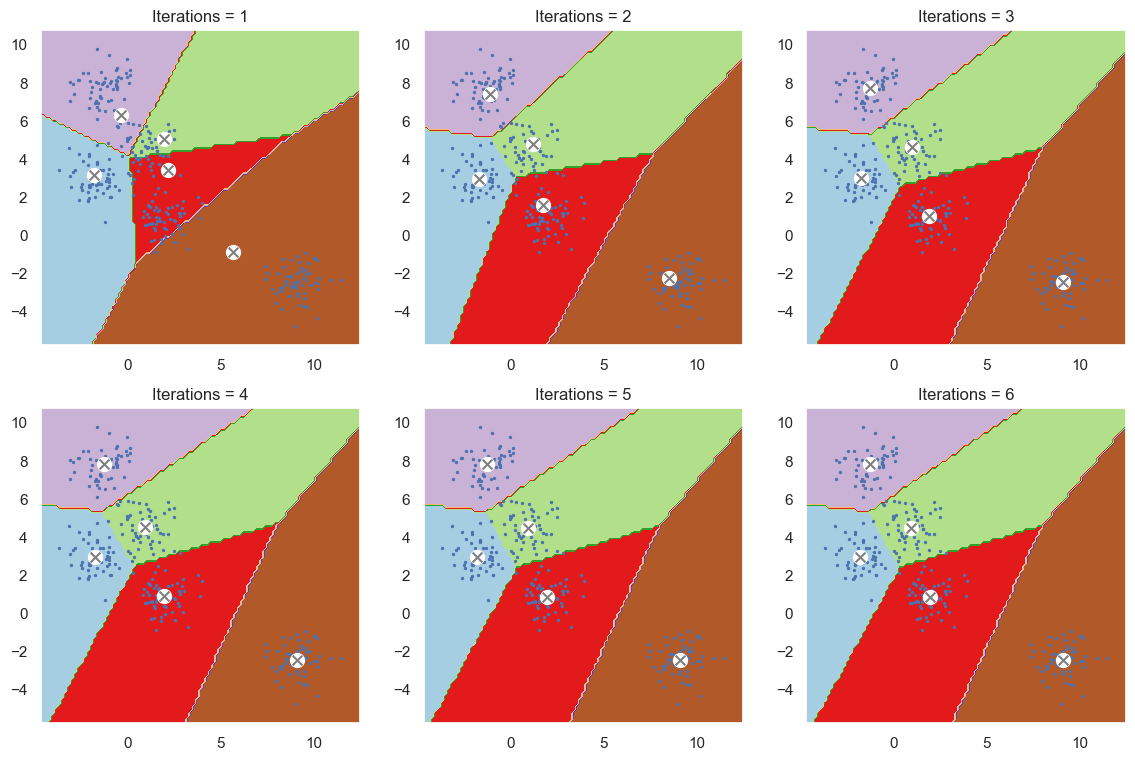

In [4]:
fig, ax = plt.subplots(2, 3, figsize=(14,9)) # set up 2 by 3 subplots on a figure of size 14 x 9
# loop over the number of iterations and the axes
# flat flattens the array to a one-dimensional array
for niter, axi in zip(range(1,7), ax.flat):
    # instantatiate KMeans with 5 clusters, random initial conditions,
    # only one set of initial conditions and the number of iterations specified by niter
    kmeans = KMeans(n_clusters=5, init='random', n_init=1, max_iter=niter, random_state=0)
    kmeans.fit(X) # fit the data to the model
    y_kmeans = kmeans.predict(X) # get predictions of labels from the model

    # plot the decision boundaries on the current axes
    plt_decision_boundaries(kmeans,xx,yy,ax=axi) 
    axi.scatter(X[:,0], X[:,1], s=2, cmap='viridis') # plot the data points
    centers = kmeans.cluster_centers_ # get the cluster centres from the model
    # plot the centres as a black cross on a white circle
    axi.scatter(centers[:,0], centers[:,1], c='white', s=100, alpha=1.)
    axi.scatter(centers[:,0], centers[:,1], c='black', marker='x', s=50, alpha=0.5)
    # put the number of iterations in the title
    axi.set_title('Iterations = {0}'.format(niter))

As the initial conditions are chosen randomly, different final classifications can result. An example is shown below for two different random initial conditions. The left figure is the final classification for the sequence shown in the previous cell. We can see that the left figure gives a better classification of the clusters, but in general to make a decision we need a metric. The metric that is used by `KMeans` is known as the *inertia*, and corresponds to the sum of the squared distances from each sample to the closet cluster centre. Using this we see that the left figure has an inertia which is half that of the right figure.

The default behaviour of `KMeans` is to use an algorithm known as *K-Mean++* to choose the initial conditions. This chooses the first cluster centre randomly and then chooses the other centres so that they are well spaced across the distribution of points. This results in a decrease in times the algorithm needs to run to converge to the optimal solution. `KMeans` also is repeated with random initial conditions, and then the final configuration with the lowest inertia is chosen. The default number of runs of `KMeans` is `n_init=10`.

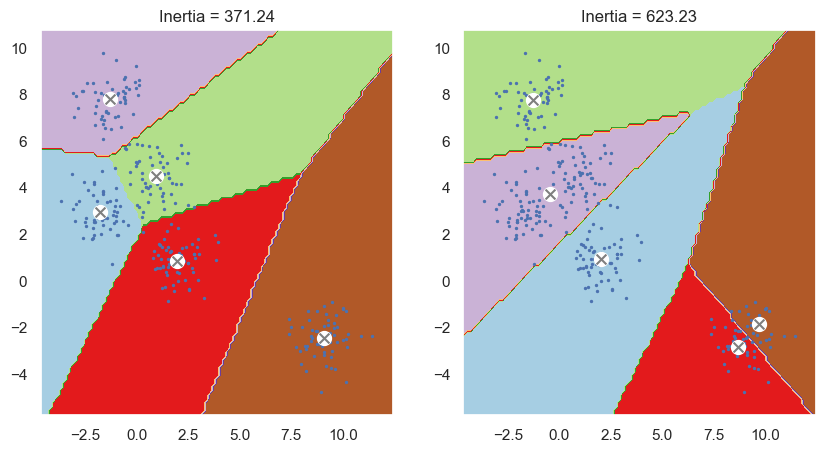

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,5)) # set up 2 subplots a figure of size 10 x 5
# loop over two random number seeds and the axes
# flat flattens the array to a one-dimensional array
for rstate, axi in zip(np.array([0,42]), ax.flat):
    # instantatiate KMeans with 5 clusters, random initial conditions,
    # only one set of initial conditions and the random seed specified by rstate
    kmeans = KMeans(n_clusters=5, init='random', n_init=1, random_state=rstate)
    kmeans.fit(X) # fit the data to the model
    y_kmeans = kmeans.predict(X) # get predictions of labels from the model

    # plot the decision boundaries on the current axes
    plt_decision_boundaries(kmeans,xx,yy,ax=axi)
    axi.scatter(X[:,0], X[:,1], s=2, cmap='viridis') # plot the data points
    centers = kmeans.cluster_centers_ # get the cluster centres from the model
    # plot the centres as a black cross on a white circle
    axi.scatter(centers[:,0], centers[:,1], c='white', s=100, alpha=1.)
    axi.scatter(centers[:,0], centers[:,1], c='black', marker='x', s=50, alpha=0.5)
    # put the inertia in the title
    axi.set_title('Inertia = {0}'.format(np.round(kmeans.inertia_,2)))

In this example it is easy to choose the initial guess of the number of clusters. In practise, we do not know beforehand the optimal number of clusters and we need to undertake a parameter search to determine this. The figure below shows the the effect of changing `n_clusters` for the blobs data. For 4 clusters it can be seen that the brown region is made up of 2 clusters, while for 6 clusters the brown and green regions are actually 1 cluster. The inertia for each of these optimal solutions is also shown, and it is apparent that this decreases with the number of clusters. In general this will occur for the optimal solutions. However, between 4 and 5 the inertia decreases by over a factor of 2, while between 5 and 6 the inertia only decrease by a factor of 1.1.

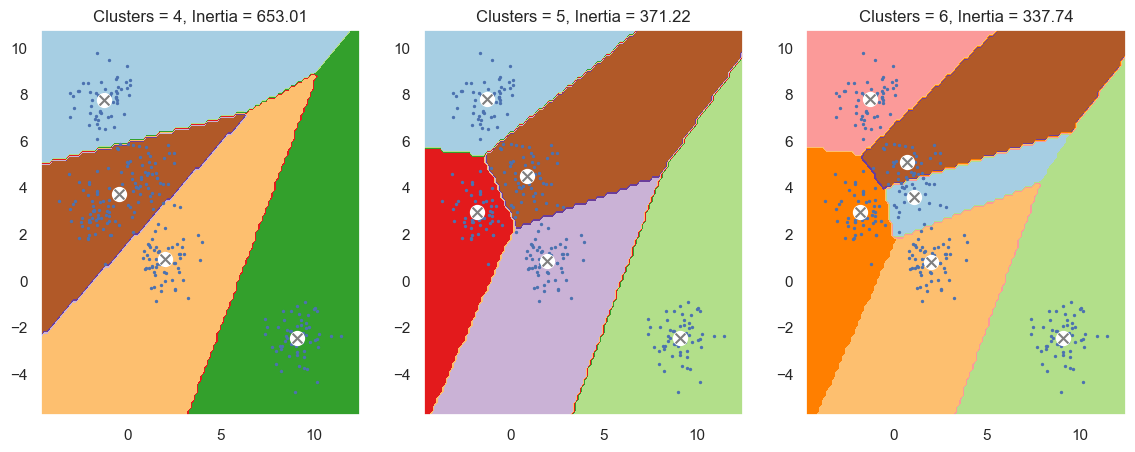

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(14,5))# set up 3 subplots a figure of size 14 x 5
# loop over the number of clusters and the axes
# flat flattens the array to a one-dimensional array
for ncl, axi in zip(range(4,7), ax.flat):
    # instantatiate KMeans with ncl clusters
    kmeans = KMeans(n_clusters=ncl)
    kmeans.fit(X) # fit the data to the model
    y_kmeans = kmeans.predict(X) # get predictions of labels from the model

    # plot the decision boundaries on the current axes
    plt_decision_boundaries(kmeans,xx,yy,ax=axi)
    axi.scatter(X[:,0], X[:,1], s=2, cmap='viridis') # plot the data points
    centers = kmeans.cluster_centers_  # get the cluster centres from the model
    # plot the centres as a black cross on a white circle
    axi.scatter(centers[:,0], centers[:,1], c='white', s=100, alpha=1.)
    axi.scatter(centers[:,0], centers[:,1], c='black', marker='x', s=50, alpha=0.5)
    # put the number of clusters and inertia in the title
    axi.set_title('Clusters = {0}, Inertia = {1}'.format(ncl,np.round(kmeans.inertia_,2)))

We can investigate the inertia of a wider range of values of `n_clusters`, and this is shown below. Up until 5 clusters, we obtain a dramatic reduction in the inertia for the addition of each cluster, but after 5 clusters there is only a marginal reduction in the inertia for the addition of each cluster as all the algorithm is doing is splitting clusters. The optimal value of `n_clusters` then occurs on the *elbow* of the curve where the return changes from dramatic to marginal. However, determining this point is subjective. We could multiply the inertia by an increasing function, e.g., the number of clusters, and then we see there is a minimum at 5 clusters.

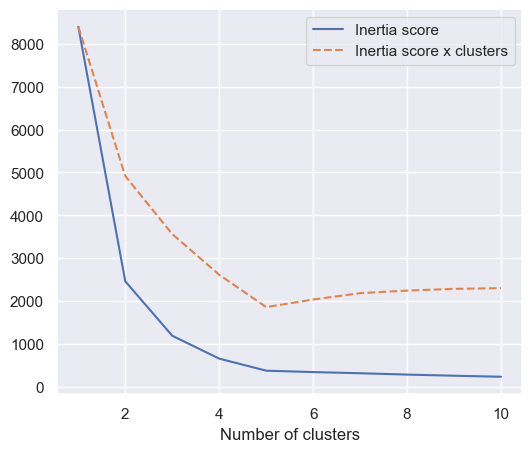

In [7]:
nclusters = np.arange(1,11) # create an array of the number clusters to investigate
inertia_score = [] # initialize an array for the inertia score
for ncl in nclusters: # loop over the number of clusters
    # instantatiate KMeans with ncl clusters
    kmeans = KMeans(n_clusters=ncl)
    kmeans.fit(X) # fit the data to the model
    # obtain the inertia score from the model and append the current value to the 
    # array inertia_score
    inertia_score.append(kmeans.inertia_) 

fig = plt.figure(figsize=(6,5)) # set up a figure of size 6 x 5
# plot the inertia score and nclusters*(inertia score)
plt.plot(nclusters,inertia_score,'-',label='Inertia score')
plt.plot(nclusters,nclusters*inertia_score,'--',label='Inertia score x clusters')
plt.legend() # put a legend in the best place
plt.xlabel('Number of clusters'); # add an x label

A more objective way to determine the optimal number of clusters is to use the *silhouette score*. The *silhouette coefficient* for an individual sample is defined as $(b-a)/max(a,b)$, where $a$ is the mean distance from that sample to all other points in that cluster, and $b$ is the distance to the centre of the next closest cluster. If the silhouette coefficient is close to 1 then that suggests that the point is in the correct cluster, and if it is close to -1 that it is in the incorrect cluster. If the coefficient is near 0, this suggest that the point is near the boundary of two clusters. The *silhouette score* is then the mean of the *silhouette coefficient* for all points. The silhouette score can be calculated using the `sklearn` function `silhouette_score`. Repeating the previous calculation it can be seen the score reaches a maximumum at 5 clusters.

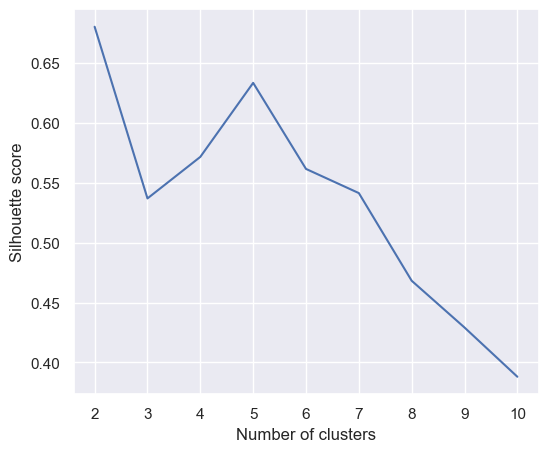

In [8]:
from sklearn.metrics import silhouette_score 

nclusters = np.arange(2,11)  # create an array of the number clusters to investigate
slh_score = []  # initialize an array for the silhouette score
for ncl in nclusters: # loop over the number of clusters
    # instantatiate KMeans with ncl clusters and fit the data to the model
    kmeans = KMeans(n_clusters=ncl, random_state=0).fit(X)
    # calculate the silhouette score and append the current value to the 
    # array silhoutte_score
    slh_score.append(silhouette_score(X, kmeans.labels_))

fig = plt.figure(figsize=(6,5)) # set up a figure of size 6 x 5
# plot the silhouette score
plt.plot(nclusters, slh_score)
plt.xlabel('Number of clusters'); # add an x label
plt.ylabel('Silhouette score'); # add a y label

`KMeans` works best on spherical clusters, therefore it is important to normalise variables prior to fitting this model. For more complicated distributions, generalizations of `KMeans`, such as spectral clustering, DBSCAN and Gaussian mixture models need to be applied to the data.

### Classifying Digits

In the previous lesson we investigated using dimensionality reduction on the digits data. Now we can use `KMeans` to classify the data, and compare the results with and without using PCA. We first load the dataset, which gives 1797 instances of 8 x 8 images or 64 features.

In [9]:
from sklearn.datasets import load_digits
digits = load_digits() # load the digits data set
print('Shape of digits data:',digits.data.shape) # print the shape of the data

Shape of digits data: (1797, 64)


As we know that there are 10 separate digits, we will assume that this is also the optimal number of clusters. To determine the effectiveness of `KMeans` in classifying the digits we can view the image at the cluster centre. Since there are 10 clusters, this is a flattened 8 x 8 image. To plot the image we reshape this into 8 by 8 images. As can be seen, all the images seem to be indentified, although the 8 is a little indistinct.

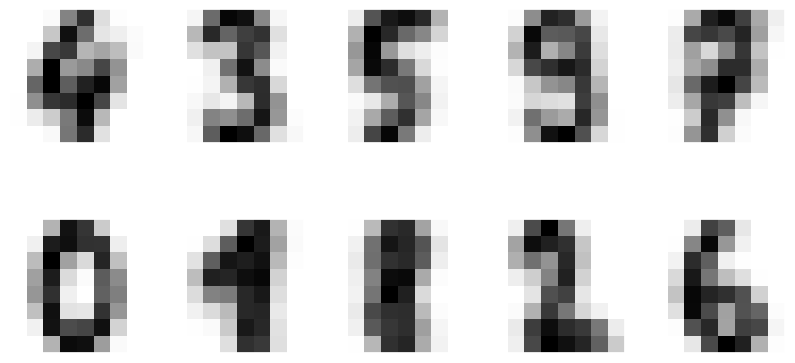

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)  # instantatiate KMeans with 10 clusters 
clusters = kmeans.fit_predict(digits.data) # fit the digits data to the model

fig, ax = plt.subplots(2, 5, figsize=(10,5)) # set up 2 x 5 subplots on a figure of size 10 x 5

# extract the centres positions from the model and reshape from a 10 x 64 array to a 10 x 8 x 8 array
centers = kmeans.cluster_centers_.reshape(10, 8, 8) 
# loop over the subplot axes and the cluster centres
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[]) # don't show x or y annotations on this plot
    axi.imshow(center, cmap=plt.cm.binary) # plot in binary the image for the current centre

To determine the accuracy of `KMeans` we need to assign a label (number) to each cluster. As the `KMeans` does not order the clusters in an order related to the digits, we need to assign a label to the cluster by searching through each cluster and finding the most common label (mode) in that cluster.

In [11]:
from scipy.stats import mode

labels = np.zeros_like(clusters) # create an array of zeros of the same size as clusters
for i in range(10): # loop over the indicies for the clusters
    mask = (clusters == i) # find the index of all points in the current cluster
    # find the most common label(mode) for the points in the current cluster
    # and assign that as the predicted label for the points in the current cluster
    # we take the first value in the array, as the could be multiple modes
    labels[mask] = mode(digits.target[mask])[0]

/var/folders/zd/pjtt9jh91n3bgsbpp5t1kf99vjyk0v/T/ipykernel_19325/1522058028.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


We can now determine the accuracy of `KMeans` by comparing the predicted value against the actual values. This gives an accuracy of 80%, which is very good considering the minimal effort in setting up the model.

In [12]:
from sklearn.metrics import accuracy_score
# calculate the accuracy score by using the actual and predicted labels
# and print this
print('Accuracy of KMeans is',np.round(accuracy_score(digits.target, labels),3))

Accuracy of KMeans is 0.794


To see where `KMeans` breaks down, we can view the confusion matrix. From this it is apparent that the main mistakes are that 1 is mistaken for 2 and 8, 5 and 8 mistaken for 9, and 9 is mistaken for 1.

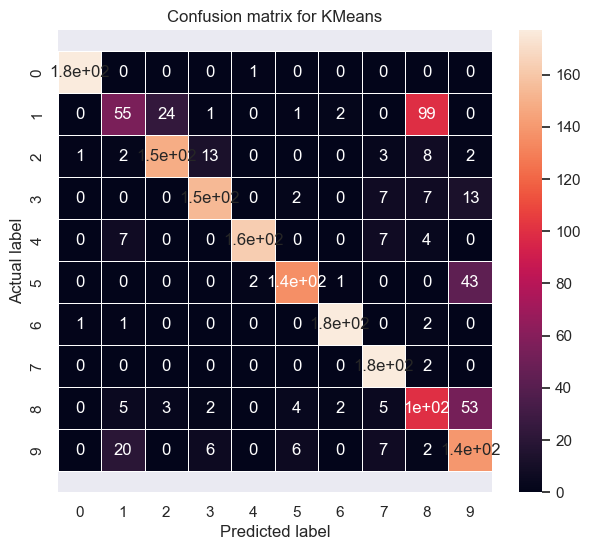

In [13]:
# plot the confusion matrix by using the actual and predicted labels
cnf_matrix = confusion_matrix(digits.target, labels)
plt_confusion_matrix(cnf_matrix, digits.target_names, 'KMeans')

The above process can be repeated, but first reducing the dimension of the data set using PCA. In this case we choose to account for 90% of the variance, and as a result the size of the data set is reduced to 1/3 of its original size.

In [14]:
from sklearn.decomposition import PCA
pca = PCA(0.9) #instantatiate PCA to calculate with 90% of the explained variance
projected = pca.fit_transform(digits.data) # fit the data and transform to component space

kmeans = KMeans(n_clusters=10, random_state=0)  # instantatiate KMeans with 10 clusters 
clusters = kmeans.fit_predict(projected) # fit the digits data to the model
print('Shape of cluster centres is',kmeans.cluster_centers_.shape) # print the shape of the cluster centres

Shape of cluster centres is (10, 21)


Using only the first 21 PC does not significantly effect the accuracy, which is only reduced by 0.2%.

In [15]:
labels = np.zeros_like(clusters)  # create an array of zeros of the same size as clusters
for i in range(10): # loop over the indicies for the clusters
    mask = (clusters == i)  # find the index of all points in the current cluster
    # find the most common label(mode) for the points in the current cluster
    # and assign that as the predicted label for the points in the current cluster
    # we take the first value in the array, as the could be multiple modes
    labels[mask] = mode(digits.target[mask])[0]
    
# calculate the accuracy score by using the actual and predicted labels
# and print this
print('Accuracy of KMeans + PCA is',np.round(accuracy_score(digits.target, labels),3))

Accuracy of KMeans + PCA is 0.794


/var/folders/zd/pjtt9jh91n3bgsbpp5t1kf99vjyk0v/T/ipykernel_19325/1498166224.py:7: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  labels[mask] = mode(digits.target[mask])[0]


Similarly, the patterns which are viewed in the confusion matrix are only marginally changed.

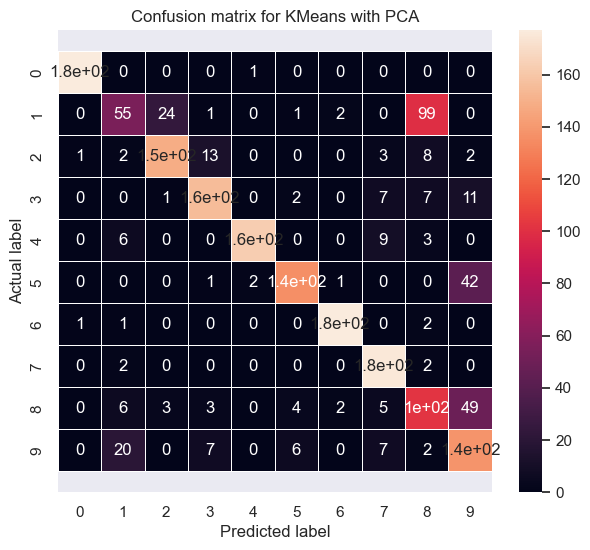

In [16]:
# plot the confusion matrix by using the actual and predicted labels
cnf_matrix = confusion_matrix(digits.target, labels)
plt_confusion_matrix(cnf_matrix, digits.target_names, 'KMeans with PCA')

### Image Compression and Segmentation

Finally, we can view an example of how `KMeans` can be used for image compression or segmentation. A typical image is stored as an array, where at each point the Red, Blue and Green intensity is specified. The intensity is generally an integer between 0 and 255. Consequently the number of colours in an image is $256^3 = 16,777,216$. Reducing the number of colours that are used allows the size of the image to be reduced significantly by compression algorithms. 

`Kmeans` can also be used for image segmentation. If we assume the regions of the image are of similar colours and assign the 'average' colour to that region, then the image can be divided into segments based on these colours.

For the lorikeet image there are 1024 by 678 pixels, and at each pixel there are values for Red, Blue and Green.

In [17]:
lorikeet = plt.imread('RainbowLorikeet.jpg') # load an image of a rainbow lorikeet
print('Shape of the image array is',lorikeet.shape) # print the shape of the image array

Shape of the image array is (1024, 768, 3)


There are a number of distinct colour regions in the image, with gradations in each of the regions.

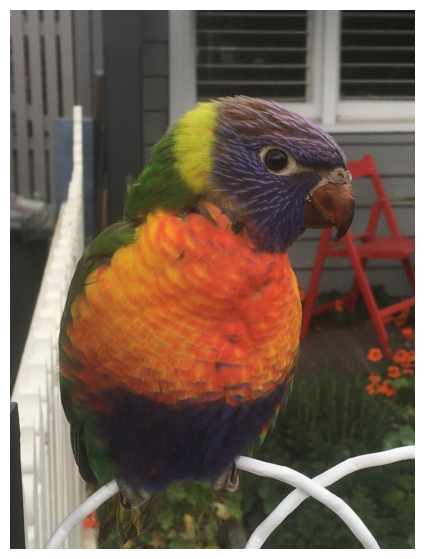

In [18]:
fig = plt.figure(figsize=(7,7)) # initialize a figure of size 7 x 7
plt.imshow(lorikeet) # display the image
plt.axis('off'); # turn off axis annotations

To process the data we normalize the intensities so that they lie between 0 and 1, and reshape the array so that each pixel is an instance and we have 3 features at each pixel, being the individual colour intensity.

In [19]:
data = lorikeet/255.0 # normalize the intensities so they are between 0 and 1
data = data.reshape(1024*768, 3) # reshape the image to a samples x features array
print('Shape of the data array is',data.shape) # print the shape of the data array

Shape of the data array is (786432, 3)


We now plot the colour intensity as a three dimensional array. As there are a large number of points, we plot a random sample of the points

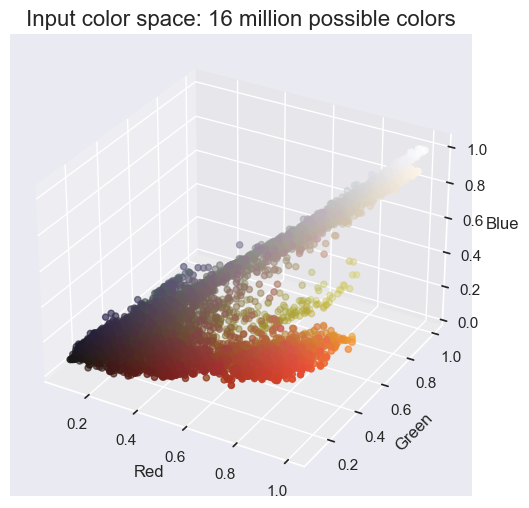

In [20]:
from mpl_toolkits import mplot3d # import function to enable 3-dimensional plotting in matplotlib
def plot_3d_pixels(data, title, colors=None, N=10000):
    '''plot pixels from an image on 3d (R,G,B) axes, using a random sample of the pixels'''
    if colors is None: # if colors is not specified using the data
        colors = data
        
    # choose a random subset
    rng = np.random.RandomState(0) # initialize a random permutation
    # randomly permute the pixels and choose the indices for the first N
    i = rng.permutation(data.shape[0])[:N] 
    colors = colors[i] # choose the random colours
    # choose the random intensities and assign to the one-dimensional arrays R, G and B
    # T is the transpose
    R, G, B = data[i].T 
    
    fig = plt.figure(figsize=(8,6)) # set up a figure of size 8 x 6
    ax = plt.subplot(projection='3d') # initialize the 3d axes
    # 3d scatter plot with points coloured by their targets values
    p = ax.scatter3D(R, G, B, c=colors)
    ax.set_xlabel('Red') # add x label
    ax.set_ylabel('Green') # add y label
    ax.set_zlabel('Blue') # add z label
    ax.set_title(title,size=16) # add a title
    
# plot the intensities for the full image
plot_3d_pixels(data, title='Input color space: 16 million possible colors'); 

We now cluster the RGB data into 16 clusters. As there is a large number of points we use `MiniBatchKMeans`, which implements the `KMeans` algorithm but on a random batch of samples on each training iteration. This converges faster than `Kmeans`, with a marginal loss of accuracy. The points are now coloured according to their cluster. There are some distinct clusters, but the effect is more to break up the continuous variation of colours.

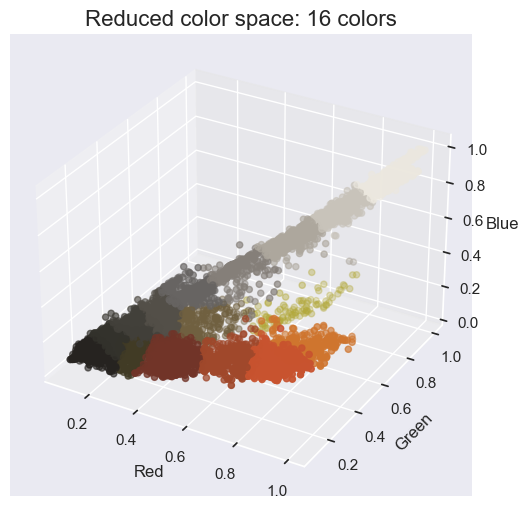

In [21]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16) # instantatiate MiniBatchKMeans with 16 clusters
kmeans.fit(data) # fit the data to the model
# assign the labels for each of the clusters by predict the colour at the cluster centre
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

# plot the intensities for the clustered image
plot_3d_pixels(data, colors=new_colors, title='Reduced color space: 16 colors')

The clustered data can now be reshaped into an image and compared with the original image. With only one millionth of the colors there is some loss of quality, but the general features of the image are not changed. The advantage of the clustering is that when compressed the reduced image results in a file size that is orders of magnitude smaller than the original image.

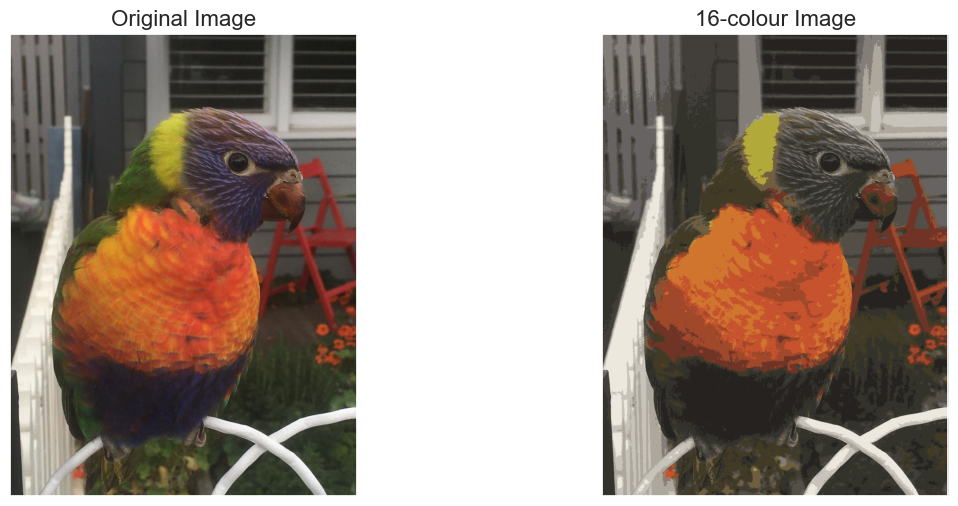

In [22]:
# reshape the clustered array to the shape of the original image
lorikeet_recoloured = new_colors.reshape(lorikeet.shape) 

fig, ax = plt.subplots(1, 2, figsize=(14,6)) # set up 2 subplots on figure of size 14 x 6
                       
ax[0].set(xticks=[], yticks=[]) # don't show x or y annotations on this plot
ax[0].imshow(lorikeet) # plot the original image
ax[0].set_title('Original Image',size=16) # add a title
ax[1].set(xticks=[], yticks=[]) # don't show x or y annotations on this plot
ax[1].imshow(lorikeet_recoloured) # plot the compressed image
ax[1].set_title('16-colour Image',size=16); # add a title